This notebook runs the event segmentation analyses.

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import brainiak.eventseg.event as event
import hypertools as hyp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
import pickle

def score_model(mcorr, model, k, s):
    i1, i2 = np.where(np.round(model.segments_[0])==1)
    w = np.zeros_like(model.segments_[0])
    w[i1,i2] = 1
    w = np.dot(w, w.T).astype(bool)
    return mcorr[w].mean()/mcorr[~w].mean() - k/s
    
def reduce_model(m, ev):
    """Reduce a model based on event labels"""
    w = (np.round(ev.segments_[0])==1).astype(bool)
    return np.array([m[wi, :].mean(0) for wi in w.T])

%matplotlib inline

## Setting paths

In [2]:
datadir = '../../../data/processed/'

## Load data

In [3]:
video_model, recall_models = np.load(datadir+'models_t100_v50_r10.npy')

## Find optimal k for video model

In [63]:
from scipy.stats import entropy

nEvents = np.arange(2,51)
wd = np.zeros(len(nEvents))
corrmat = np.corrcoef(video_model)

for i, events in enumerate(nEvents):
    ev = event.EventSegment(events)
    ev.fit(video_model)
    t = np.round(ev.segments_[0]).astype(int)
    mask = np.sum(list(map(lambda x: np.outer(x, x), t.T)), 0).astype(bool)

    # Create mask such that the maximum temporal distance for # within and across correlations is the same
    local_mask = np.zeros(mask.shape, dtype=bool)
    for k in range(mask.shape[0]):
        if ~np.any(np.diag(mask,k)):
            break
        local_mask[np.diag(np.ones(local_mask.shape[0]-k, dtype=bool), k)] = True
    within_vals = np.reshape(corrmat[mask*local_mask], -1, 1) 
    across_vals = np.reshape(corrmat[~mask*local_mask], -1, 1)
    within_hist = np.histogram(within_vals, range=(-1, 1), bins=100)[0]
    across_hist = np.histogram(across_vals, range=(-1, 1), bins=100)[0]
    wd[i] = 1 - corr(within_hist, across_hist)[0]
    print(events, wd[i])

2 0.00129547578509
3 0.00430699695956
4 0.00982981553045
5 0.0185166612542
6 0.0302641092786
7 0.0625590618466
8 0.0818761452414
9 0.161451656206
10 0.226705427517
11 0.342564814642
12 0.422419283536
13 0.549384013793
14 0.660831940134
15 0.672064359016
16 0.795486983555
17 0.835737644008
18 0.809883052532
19 0.898317021408
20 0.943819043988
21 0.99739365011
22 0.97627032179
23 0.971225119059
24 0.97096882102
25 0.98945021654
26 0.982409250815
27 0.981844809793
28 0.977109729496
29 0.979831197423
30 0.971376495599
31 0.975742989101
32 0.973110436675
33 0.968815422786
34 0.964291358806
35 0.961712789409
36 0.967701017012
37 0.966300378782
38 0.967120101316
39 0.958637651197
40 0.967837920477
41 0.905506349248
42 0.907427895119
43 0.957881033194
44 0.905938933805
45 0.899351312973
46 0.89622797235
47 0.883881469613
48 0.892553365632
49 0.836352341999
50 0.860258717778


## Plot the within and across correlation values as a function of k

21


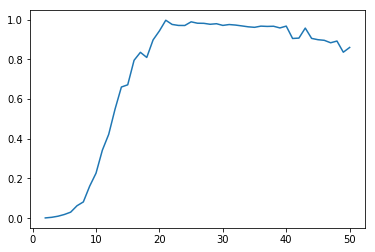

In [64]:
plt.plot(nEvents, wd)
maxk_video = nEvents[np.argmax(wd)]
print(maxk_video)

## Plot the ratio of within/across ratio as a function of k

## Fit event segmentation model to video

In [34]:
ev = event.EventSegment(maxk_video)
ev.fit(video_model)
video_events = reduce_model(video_model, ev)

## Save models

In [36]:
with open(datadir+'/video_eventseg_model_entropy', 'wb') as f:
    pickle.dump(ev, f)
np.save(datadir+'video_events_entropy', video_events)

## Get video event times

In [37]:
video_event_times = []
for s in ev.segments_[0].T:
    tp = np.where(np.round(s)==1)[0]
    video_event_times.append((tp[0], tp[-1]))
np.save(datadir+'video_event_times_entropy', video_event_times)

## Fit event segmentation model to recall

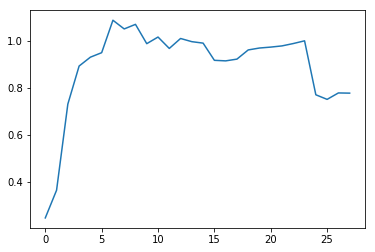

0 8


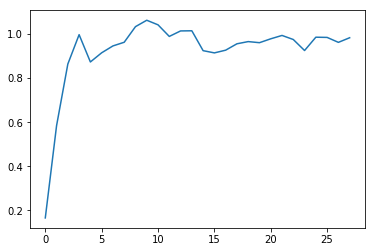

1 11


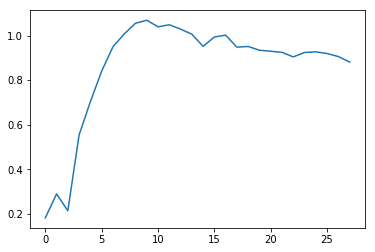

2 11


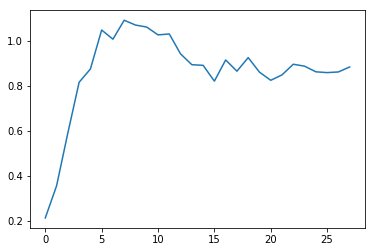

3 9


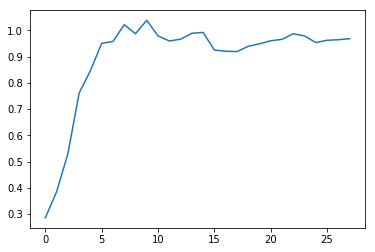

4 11


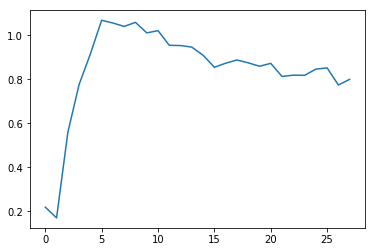

5 7


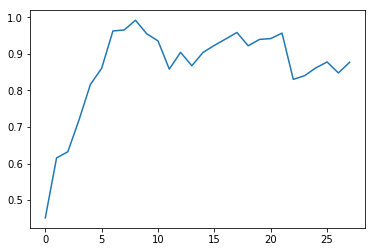

6 10


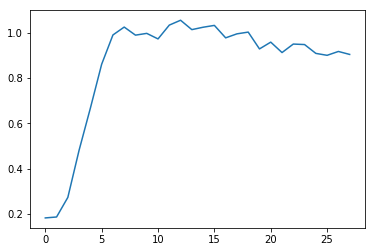

7 14


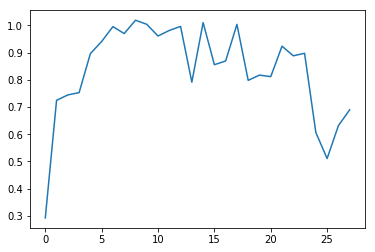

8 10


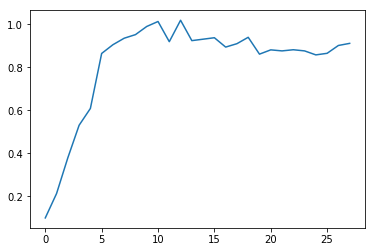

9 14


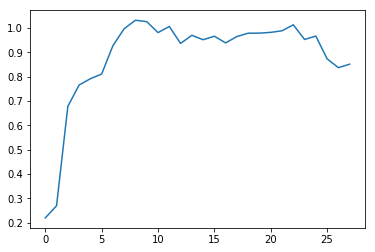

10 10


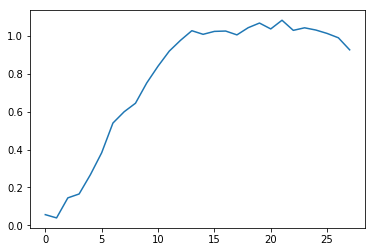

11 23


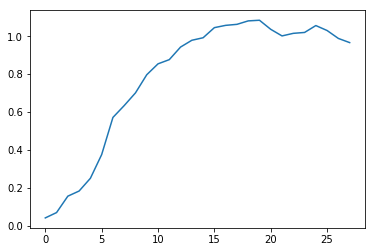

12 21


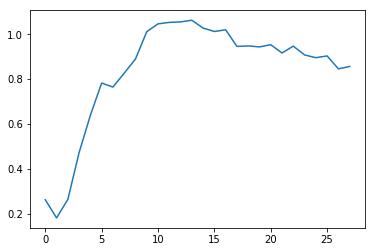

13 15


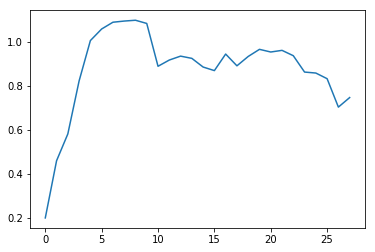

14 10


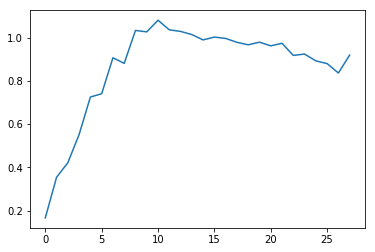

15 12


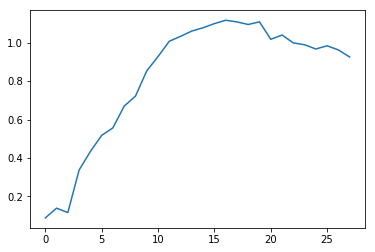

16 18


In [60]:
from scipy.stats import pearsonr as corr

ks = list(range(2, 30))
maxk = []
for i, sub in enumerate(recall_models):
    mcorr = np.corrcoef(sub)
    cs = []
    for k in ks:
        ev = event.EventSegment(k)
        ev.fit(sub)
        i1, i2 = np.where(np.round(ev.segments_[0])==1)
        w = np.zeros_like(ev.segments_[0])
        w[i1,i2] = 1
        mask = np.dot(w, w.T).astype(bool)
        
        # Create mask such that the maximum temporal distance for # within and across correlations is the same
        local_mask = np.zeros(mask.shape, dtype=bool)
        for m in range(mask.shape[0]):
            if ~np.any(np.diag(mask, m)):
                break
            local_mask[np.diag(np.ones(local_mask.shape[0]-m, dtype=bool), m)] = True
        within_vals = np.reshape(mcorr[mask*local_mask], -1, 1) 
        across_vals = np.reshape(mcorr[~mask*local_mask], -1, 1)
        within_hist = np.histogram(within_vals, range=(-1, 1), bins=100)[0]
        across_hist = np.histogram(across_vals, range=(-1, 1), bins=100)[0]
        cs.append(1 - corr(within_hist, across_hist)[0])
    plt.plot(cs)
    plt.show()
    m = ks[np.argmax(cs)]
    maxk.append(m)
    print(i, m)

## Fit model to recall using best k

In [65]:
recall_events = []
recall_event_times = []
recall_eventseg_models = []
for i, k in enumerate(maxk):
    ev = event.EventSegment(k)
    ev.fit(recall_models[i])
    m = reduce_model(recall_models[i], ev)
    recall_events.append(m)
    recall_times = []
    for s in ev.segments_[0].T:
        tp = np.where(np.round(s)==1)[0]
        recall_times.append((tp[0], tp[-1]))
    recall_event_times.append(recall_times)
    recall_eventseg_models.append(ev)

## Create average recall model

In [66]:
matches = np.array([np.argmax(1 - cdist(video_events, r, 'correlation'), 0) for r in recall_events])
avg_recalls = [[] for _ in video_events]
for match, r in zip(matches, recall_events):
    for i, m in enumerate(match):
        avg_recalls[m].append(r[i,:])
avg_recall_events = np.array(list(map(lambda r: np.mean(r, 0) if len(r)>0 else np.zeros((100,)), avg_recalls)))
# avg_recall_events = np.array([a.reshape(100,) for a in avg_recall_events if a.shape==(100,)])

## Create 2D embeddings

In [67]:
np.random.seed(10)
embeddings = hyp.reduce(recall_events+[video_events]+[avg_recall_events], reduce='UMAP', ndims=2)

## Save models

In [70]:
np.save(datadir+'avg_recall_events_corrdist', avg_recall_events)
np.save(datadir+'embeddings_corrdist', [embeddings[:-2], embeddings[-2], embeddings[-1]])
np.save(datadir+'labels_corrdist', matches)
np.save(datadir+'video_events_corrdist', video_events)
np.save(datadir+'recall_events_corrdist', recall_events)
np.save(datadir+'recall_event_times_corrdist', recall_event_times)
with open(datadir+'recall_eventseg_models_corrdist', 'wb') as f:
    pickle.dump(recall_eventseg_models, f)